In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from copy import deepcopy

In [83]:
all_energies = {}

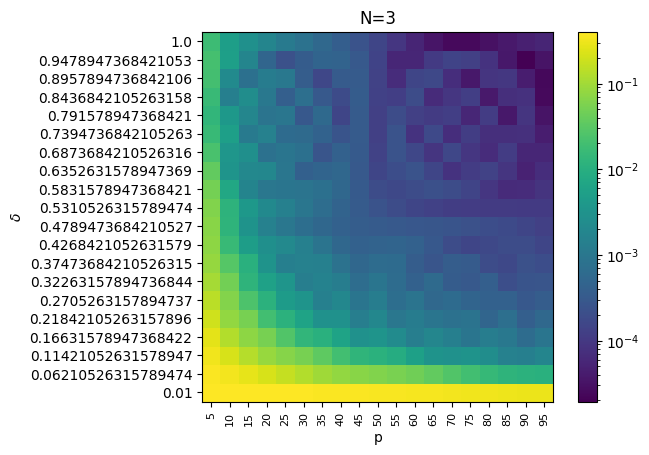

Minimum gap for N=3: 1.939274307460881e-05


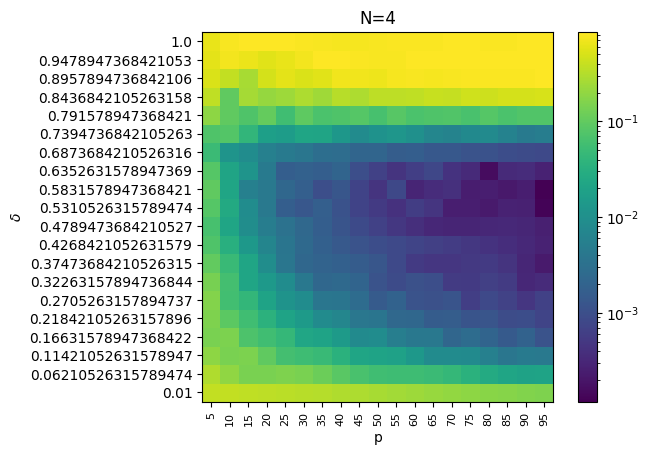

Minimum gap for N=4: 0.00011920731784809124


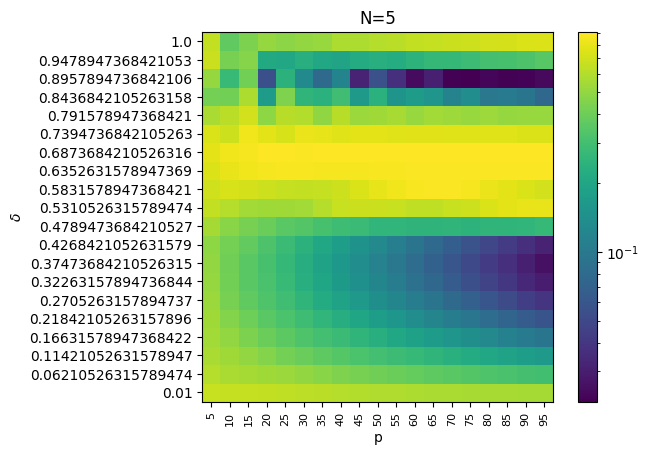

Minimum gap for N=5: 0.022125073084605984


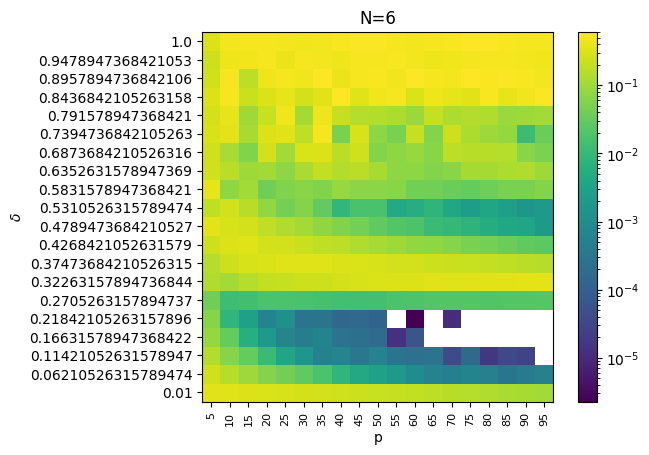

Minimum gap for N=6: -0.0001390659643538683


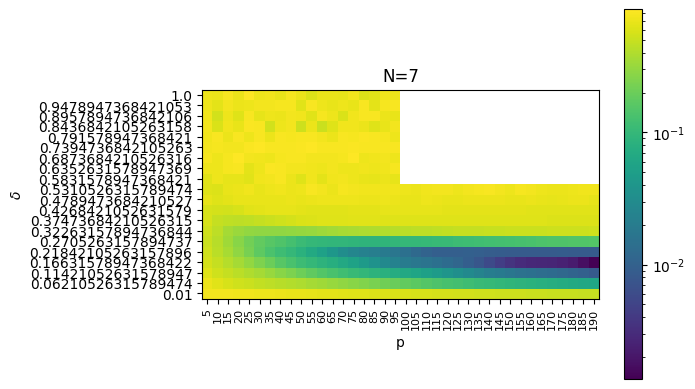

Minimum gap for N=7: 0.0013613743519119703


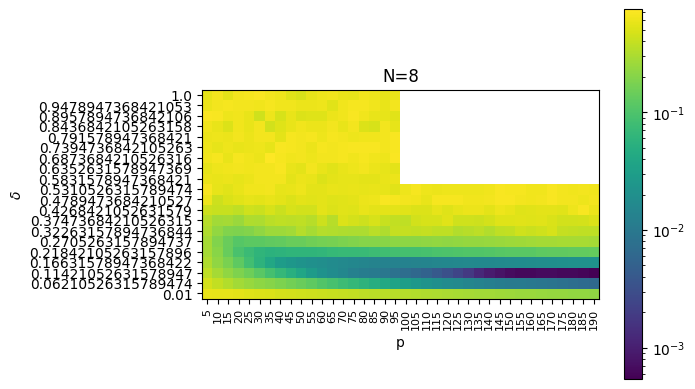

Minimum gap for N=8: 0.0005446618646616219


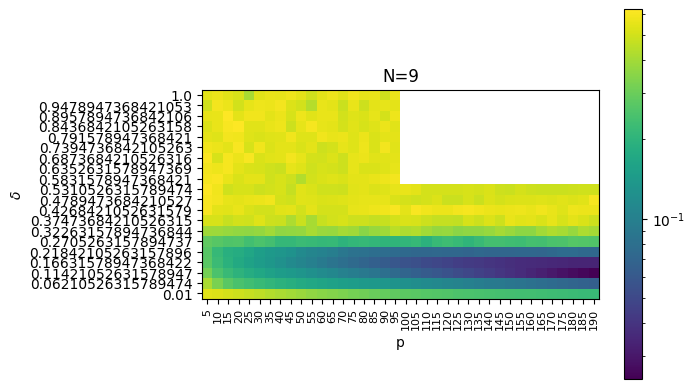

Minimum gap for N=9: 0.024612868057027115


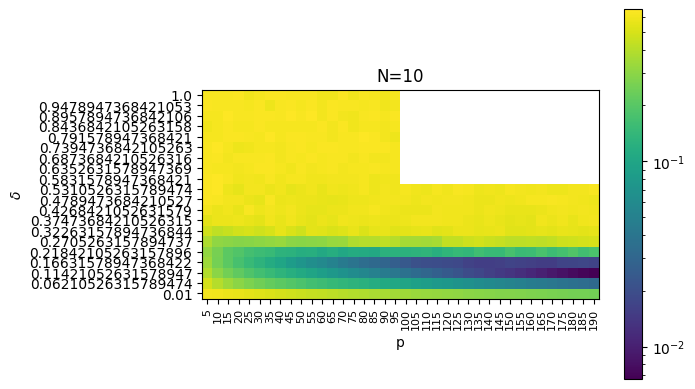

Minimum gap for N=10: 0.00667922404884469


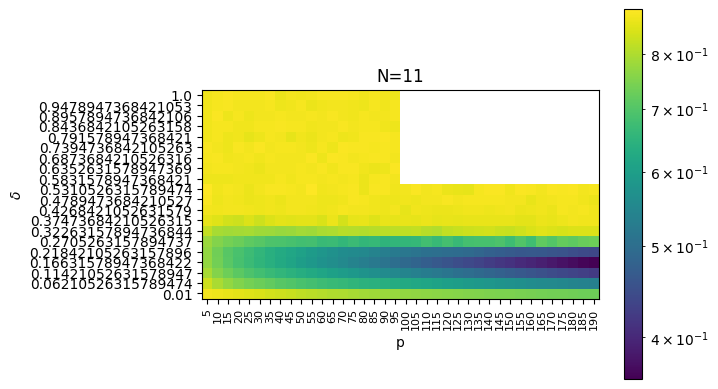

Minimum gap for N=11: 0.3612350963428518


In [142]:
for N in range(3, 20):
    fpath = f"../../../algorithms/quantum_advantage/data/phase_diagram_{N}.pickle"
    if Path(fpath).exists():
        d = pickle.load(open(fpath, "rb"))
        
        energies = d['energies']
        ps = d['ps']
        deltas = d['deltas']

        fpath_extra = f"../../../algorithms/quantum_advantage/data/phase_diagram_{N}_extra_p.pickle"
        
        if Path(fpath_extra).exists():
            d_extra = pickle.load(open(fpath_extra, "rb"))
            ps = np.hstack([ps, d_extra['ps']])
            # pad with nans if shape is different
            assert energies.shape[0] >= d_extra['energies'].shape[0]
            if energies.shape[0] > d_extra['energies'].shape[0]:
                assert energies.shape[1] == d_extra['energies'].shape[1]
                energies_extra = np.vstack([
                    d_extra['energies'],
                    np.full((energies.shape[0] - d_extra['energies'].shape[0], energies.shape[1]), np.nan)
                ])
            energies = np.hstack([energies, energies_extra])
        all_energies[N] = deepcopy(1-energies)
        
        plt.imshow(1-energies, origin='lower',norm=matplotlib.colors.LogNorm())
        plt.xticks(range(len(ps)), ps,fontsize=8, rotation=90)
        plt.xlabel('p')
        plt.yticks(range(len(deltas)), deltas)
        plt.ylabel('$\delta$')
        plt.title(f'N={N}')
        plt.colorbar()
        plt.show()
        print(f"Minimum gap for N={N}: {np.nanmin(1-energies)}")
        

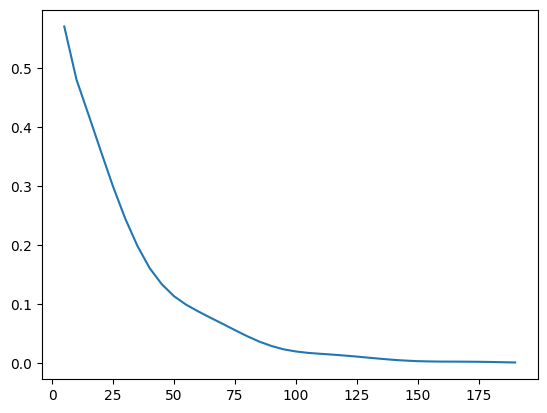

In [151]:
N = 7
ens_opt_delta = all_energies[N][
    np.unravel_index(np.nanargmin(all_energies[N]), all_energies[N].shape)[0], :
]

plt.plot(ps, ens_opt_delta)

In [152]:
ens_opt_delta[0]

0.5699632618967214

In [139]:
# optimum delta for N = 11
deltas[np.unravel_index(np.nanargmin(all_energies[11]), all_energies[11].shape)[0]]

0.16631578947368422

#### Plot a rough scaling of minimum `p` with number of spins

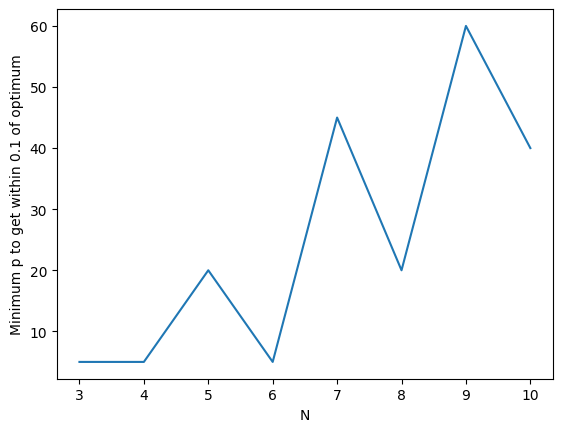

In [153]:
theshold = 0.10
Ns = []
min_ps = []
for k, v in all_energies.items():
    within_theshold_at_p = (np.min(v, axis=0) < theshold)
    if len(within_theshold_at_p.nonzero()[0]) > 0:
        Ns.append(k)
        min_ps.append(ps[within_theshold_at_p.nonzero()[0][0]])
    
plt.ylabel(f'Minimum p to get within {theshold} of optimum')
plt.xlabel('N')
plt.plot(Ns, min_ps)

# How well do the fitted ramps work?

Note: this is with no optimization, simply with delta = 0.1663

In [163]:
import sys
sys.path.append("../../../algorithms/quantum_advantage/")


In [174]:
import pandas as pd
from labs import true_optimal_mf

rows = []
for fname in Path('data/').glob("1104_ramp_*"):
    rows.append(pickle.load(open(fname, 'rb')))
    
df = pd.DataFrame(rows, columns=rows[0].keys())

df['AR'] = df.apply(
    lambda row: row['merit factor'] / true_optimal_mf[row['N']],
    axis=1
)

In [175]:
df[df['N'] == 11].sort_values('p')[['merit factor', 'p']]

,merit factor,p
172,6.147613,100
179,6.367535,110
38,6.570116,120
623,6.758741,130
126,6.947902,140
...,...,...
598,10.451776,3250
437,10.446307,3260
507,10.434086,3270
686,10.417234,3280


<AxesSubplot: xlabel='p'>

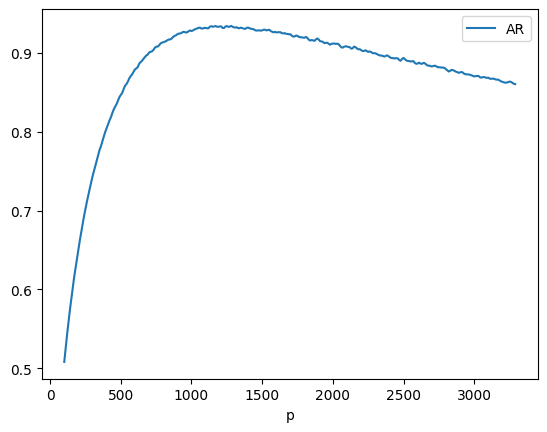

In [165]:
df[df['N'] == 11].sort_values('p').plot(x='p', y='AR')

In [168]:
df[df['N'] == 11]['AR'].max()

0.9343422725477342

N
11    AxesSubplot(0.125,0.11;0.775x0.77)
12    AxesSubplot(0.125,0.11;0.775x0.77)
13    AxesSubplot(0.125,0.11;0.775x0.77)
14    AxesSubplot(0.125,0.11;0.775x0.77)
15    AxesSubplot(0.125,0.11;0.775x0.77)
16    AxesSubplot(0.125,0.11;0.775x0.77)
17    AxesSubplot(0.125,0.11;0.775x0.77)
18    AxesSubplot(0.125,0.11;0.775x0.77)
19    AxesSubplot(0.125,0.11;0.775x0.77)
Name: AR, dtype: object

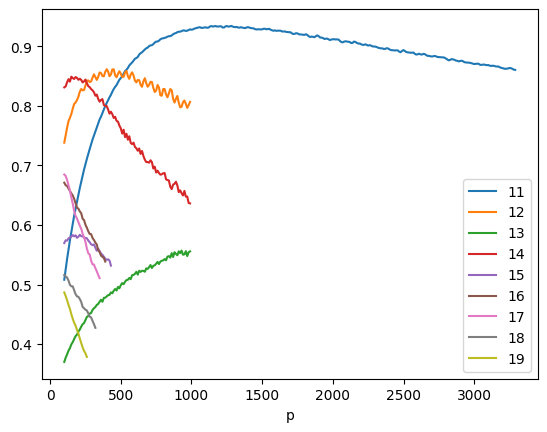

In [169]:
df.sort_values('p').set_index('p').groupby('N')['AR'].plot(legend=True)

# Now, optimize ramps

In [15]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from copy import deepcopy

In [16]:
import sys
sys.path.append("../code/")

In [35]:
import pandas as pd
from labs import true_optimal_mf

if False:
    rows = []
    for fname in Path('data/').glob("1107_optimized_ramp_*"):
        rows.append(pickle.load(open(fname, 'rb')))

    df = pd.DataFrame(rows, columns=rows[0].keys())

    df['AR'] = df.apply(
        lambda row: row['merit factor'] / true_optimal_mf[row['N']],
        axis=1
    )
else:
    df = pd.read_json('../qokit/assets/1117_ramps.json')

In [36]:
df['gap'] = 1-df['AR']

(0.01, 1)

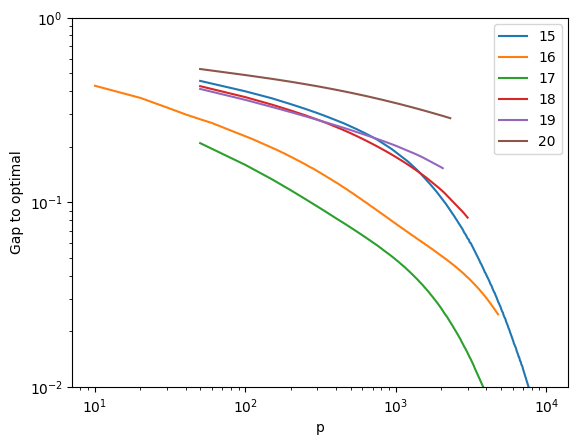

In [37]:
df[df['N']>14].sort_values('p').set_index('p').groupby('N')['gap'].plot(legend=True, logy=True, logx=True) #, colormap='viridis')
plt.ylabel('Gap to optimal')
plt.ylim(1e-2, 1)

Text(0, 0.5, 'Delta (ramp)')

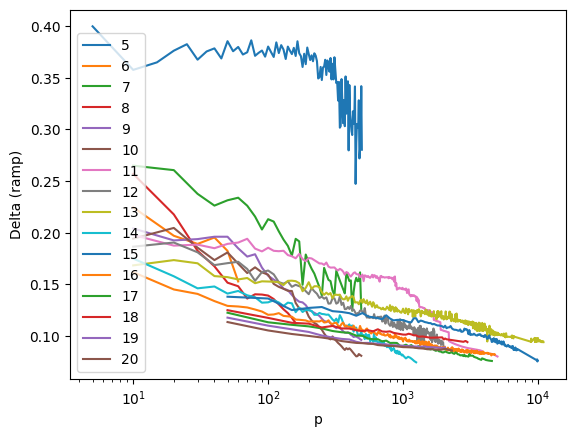

In [38]:
df.sort_values('p').set_index('p').groupby('N')['delta'].plot(legend=True, logx=True)
plt.ylabel('Delta (ramp)')

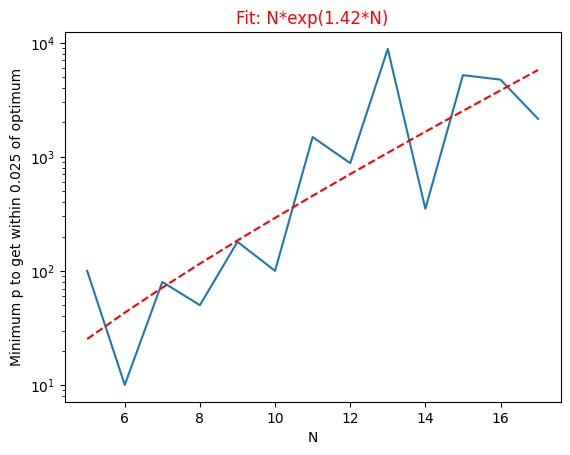

In [12]:
from sklearn.linear_model import LinearRegression

df = df[df['N'] < 18]

theshold = 0.025
Ns = sorted(set(df['N']))
min_ps = []
for N in Ns:
    min_ps.append(df[(df['gap'] < theshold) & (df['N'] == N)]['p'].min())
    
plt.ylabel(f'Minimum p to get within {theshold} of optimum')
plt.xlabel('N')
plt.yscale('log')
plt.plot(Ns, min_ps)

# to_fit = np.array([np.log(p / N) for p, N in zip(min_ps[1:], Ns[1:])]).reshape(-1, 1)
# Ns_to_fit = np.array(Ns[1:]).reshape(-1, 1)
to_fit = np.array([np.log(p / N) for p, N in zip(min_ps, Ns)]).reshape(-1, 1)
Ns_to_fit = np.array(Ns).reshape(-1, 1)

reg = LinearRegression().fit(Ns_to_fit, to_fit)

min_ps_fit = [N*np.e**(y) for y, N in zip(reg.predict(Ns_to_fit), Ns_to_fit)]
plt.plot(Ns_to_fit, min_ps_fit, linestyle='dashed', c='r')
# plt.plot(Ns_to_fit, [N*((np.e**reg.coef_[0][0])**reg.intercept_)*((np.e**reg.coef_[0][0])**N) for N in Ns_to_fit], c='k')
plt.title(f"Fit: N*exp({np.e**reg.coef_[0][0]:.2f}*N)", c='r')
plt.savefig('tmp/linear_schedules_scaling.pdf')

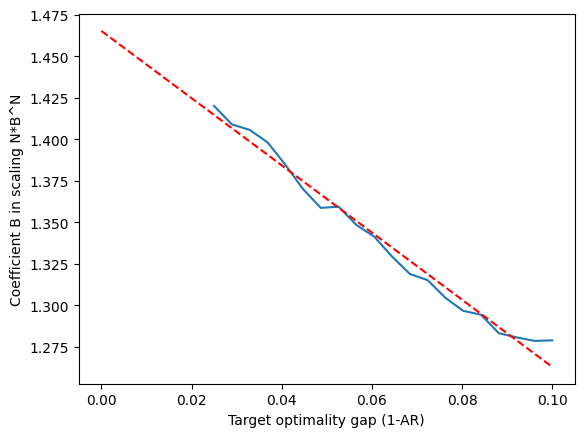

In [13]:
from sklearn.linear_model import LinearRegression

gaps = np.linspace(0.025, 0.1, 20)
exponents = []

for theshold in gaps:
    Ns = sorted(set(df['N']))
    min_ps = []
    for N in Ns:
        min_ps.append(df[(df['gap'] < theshold) & (df['N'] == N)]['p'].min())
        
    to_fit = np.array([np.log(p / N) for p, N in zip(min_ps, Ns)]).reshape(-1, 1)
    Ns_to_fit = np.array(Ns).reshape(-1, 1)

    reg = LinearRegression().fit(Ns_to_fit, to_fit)
    
    exponents.append(np.e**reg.coef_[0][0])
    
plt.plot(gaps, exponents)
plt.ylabel("Coefficient B in scaling N*B^N")
plt.xlabel("Target optimality gap (1-AR)")

exponents_to_fit = np.array(exponents).reshape(-1, 1)
gaps_to_fit = np.array(gaps).reshape(-1, 1)

reg = LinearRegression().fit(gaps_to_fit, exponents_to_fit)

gaps_to_plot = np.linspace(0.0, 0.1, 20).reshape(-1, 1)
exponents_to_plot = reg.predict(gaps_to_plot)
plt.plot(gaps_to_plot, exponents_to_plot, linestyle='dashed', c='r')
plt.savefig('tmp/linear_schedules_exponents.pdf')

/tmp/ipykernel_8288/1848076127.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


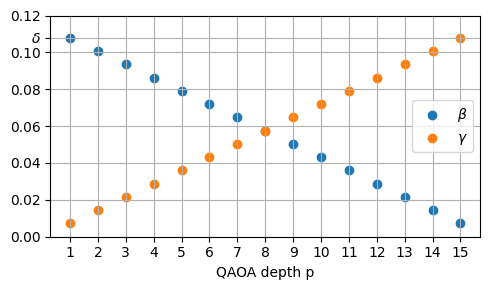

In [14]:
from utils import get_ramp

f, ax = plt.subplots(figsize=(5,3))

delta=0.115
max_p=15
ps = np.arange(1, max_p+1)
angles = get_ramp(delta, max_p)
plt.scatter(ps, angles['beta'], label=r'$\beta$')
plt.scatter(ps, -angles['gamma'], label=r'$\gamma$')
plt.legend()
ax.set_xticks(ps)
plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
labels = [w.get_text() for w in ax.get_yticklabels()]
locs=list(ax.get_yticks())
labels+=[r'$\delta$']
locs+=[max(angles['beta'])]
ax.set_yticklabels(labels)
ax.set_yticks(locs)
ax.grid()
plt.xlabel('QAOA depth p')
plt.tight_layout()
plt.savefig('tmp/ramp.pdf')

# Different sign gives wrong results

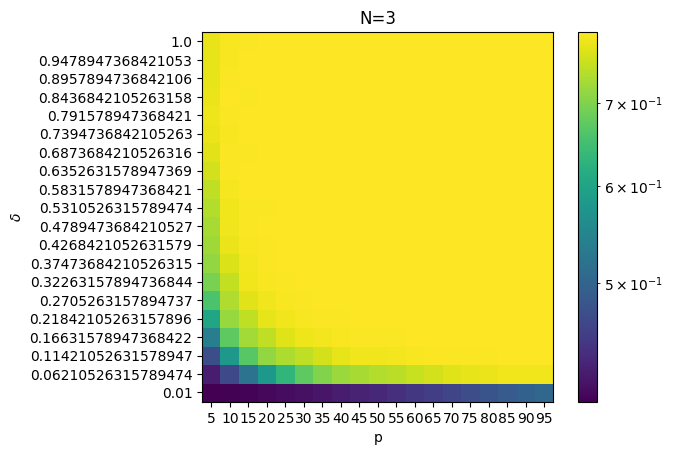

Minimum gap for N=3: 0.40062171742852026


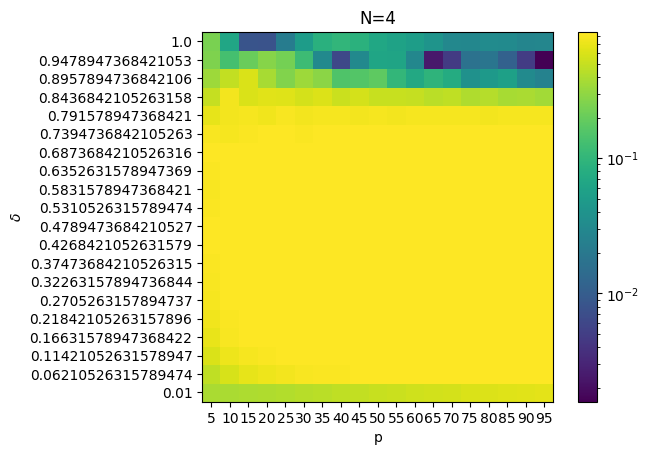

Minimum gap for N=4: 0.0015833821939249537


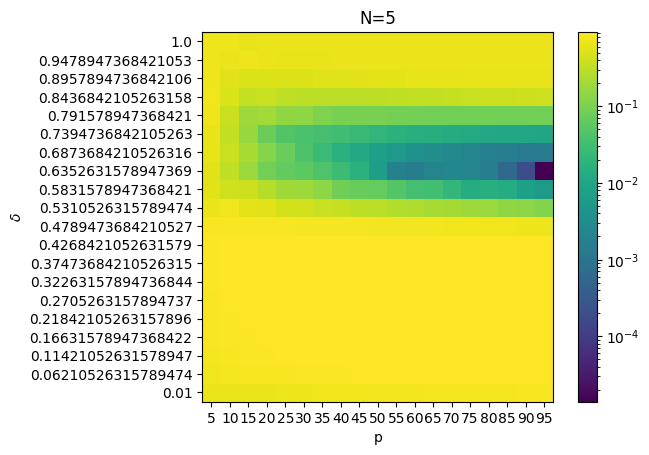

Minimum gap for N=5: 1.3895065777647098e-05


In [122]:
for N in range(3, 20):
    fpath = f"../../../algorithms/quantum_advantage/data/phase_diagram_{N}_wrong.pickle"
    if Path(fpath).exists():
        d = pickle.load(open(fpath, "rb"))
        
        energies = d['energies']
        ps = d['ps']
        deltas = d['deltas']
        
        plt.imshow(1-energies, origin='lower',norm=matplotlib.colors.LogNorm())
        plt.xticks(range(len(ps)), ps)
        plt.xlabel('p')
        plt.yticks(range(len(deltas)), deltas)
        plt.ylabel('$\delta$')
        plt.title(f'N={N}')
        plt.colorbar()
        plt.show()
        print(f"Minimum gap for N={N}: {np.nanmin(1-energies)}")
        